## Processing ZF NMR fid

### Select path of time domain data from repository and acquisition parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
from scipy.fft import fft
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Load Time-Domain Data
path = "C:/Berkeley/Papers/Metabolites/pyridine/100_pyridine/halp_compiled.npy" # Downloaded from repository
td_data = np.load(path)

# Acquisition Parameters
sampling_rate = 16666 # (Hz) From Fig. S1
acq_time = 3.932 # (s) From Fig. S1

### Useful functions

In [2]:
# Prepending Function For Backward Zero-filling
def prepend_mean(arr, n, mean):
    """
    Return array with n copies of arr.mean() prepended.
    n may be 0 or negative (returns original array).
    Preserves dtype where possible.
    """
    arr = np.asarray(arr)
    n = int(n)
    if n <= 0:
        return arr
    prepend = np.ones(n, dtype=arr.dtype) * mean
    return np.concatenate((prepend, arr))

# Assymmetric Least Squares Baseline Correction Function
def asls_baseline(y, lam, p, niter):
    """
    Asymmetric Least Squares baseline correction.
    y : 1D array (signal)
    lam : float, smoothing parameter (larger => smoother baseline)
    p : float between 0 and 1, asymmetry parameter (smaller => baseline stays below peaks)
    niter : iterations
    Returns baseline (same length as y)
    """
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    DTD = D.T @ D
    w = np.ones(L)
    for i in range(niter):
        W = sparse.diags(w, 0)
        Z = W + lam * DTD
        # spsolve expects sparse matrix; solve Z * z = w*y
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y <= z)
    return z

### Processing Function, explanation in SI Sec. II.

In [ ]:
# Post Processing function
def zf_post_processing(zf_factor, conv_points, poly_order, trunc, trunc_f, apod, start_point_shift, lambda_, p_value, n_interations, const_phase):
    """
    Processing Zero-field Data.

    Parameters
    ----------
    zf_factor : float
        Zero-filling factor (e.g., 2 increases total fid length by 200%)
    conv_points : float
        Savgol filter convolution points
    poly_order : float
        Savgol filter polynomial order
    trunc : float
        Time domain truncation points from beginning
    trunc_f : float
        Time domain truncation points from end
    apod : float
        Apodization factor (exponential decay constant)
    start_point_shift : float
        Shift in start point for time delay (1st order phase correction)
    lambda_ : float
        ASLS baseline correction smoothing parameter
    p_value : float
        ASLS baseline correction asymmetry parameter
    n_interations : int
        ASLS baseline correction number of iterations
    const_phase : float
        Constant phase correction (degrees)

    Returns
    -------
    xf : numpy.ndarray
        Frequency axis
    yf_sag_corrected : numpy.ndarray
        Processed frequency domain data
    savgol_td : numpy.ndarray
        Processed time domain data
    acq_time_effective : float
        Effective acquisition time after truncation
    """
    # Savgol Filtering
    smooth_td = scipy.signal.savgol_filter(td_data, int(float(conv_points)),int(float(poly_order)), mode="mirror")
    savgol_td = (td_data - smooth_td)
    
    # Time Domain Truncation (from the end) and acq_time correction
    savgol_td = savgol_td[:-int(trunc_f)]
    acq_time_effective = acq_time*(len(savgol_td)/len(td_data))
        
    # Apodization
    t = np.linspace(0, acq_time_effective, len(savgol_td))
    apodization_window = np.exp(-apod * t)
    savgol_td = savgol_td * apodization_window
    
    # Zero Filling
    savgol_mean = np.mean(savgol_td)
    savgol_mean_immu = savgol_mean.copy()
    savgol_td = np.concatenate((savgol_td,np.ones(int(float(len(savgol_td)*zf_factor)))*savgol_mean_immu))

    # Time Domain Truncation (from the beginning, with zero-filling to maintain length)
    savgol_td[:int(trunc)] = savgol_mean_immu
    
    # Shifting start point to impose time delay for 1st order phase correction
    if int(start_point_shift) > 0:
        savgol_td = prepend_mean(savgol_td, int(float(start_point_shift)), savgol_mean_immu)
    if int(start_point_shift) < 0:
        savgol_td = savgol_td[-int(float(start_point_shift)):]
    
    # Constant Phase Correction
    phase_radians = np.deg2rad(const_phase)
    savgol_td = savgol_td * np.exp(1j*phase_radians)
    
    # FFT
    yf_phased = fft(savgol_td)
    xf = np.linspace(0,sampling_rate,len(yf_phased))

    # Asymmetric Least Squares Baseline Correction
    yf_sag_base = asls_baseline(np.real(yf_phased), lambda_, p_value, int(n_interations))
    yf_sag_corrected = np.real(yf_phased) - yf_sag_base
    
    return(xf, yf_sag_corrected, savgol_td, acq_time_effective)

#### Processing and plotting

C:\Users\blake\AppData\Local\Temp\ipykernel_37432\627722377.py:33: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


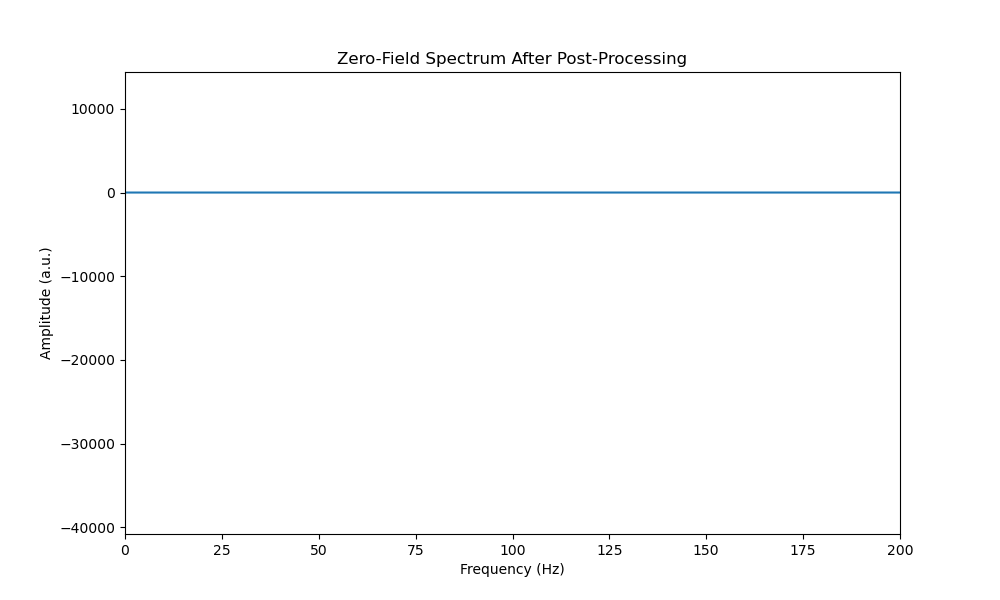

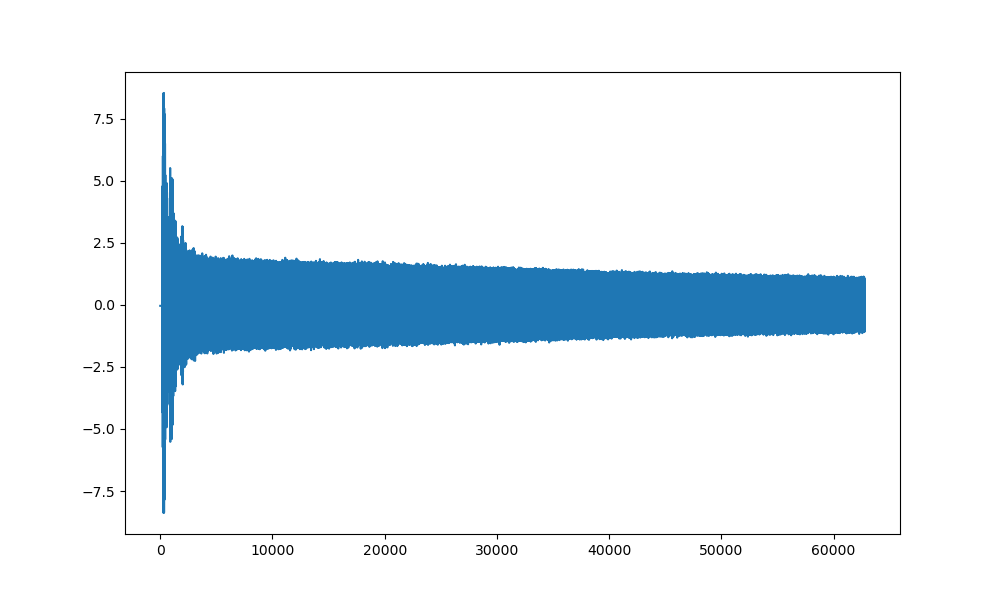

In [ ]:
%matplotlib widget
# Processing Parameters (From Fig. S2)
zf_factor = 0
conv_points = 55
poly_order = 2
trunc = 206
trunc_f = 2725
apod = .16
start_point_shift = -14 # 1st order phase Correction
lambda_ = 1000 # Assymetric least squares baseline correction parameter
p_value = .0908 # Assymetric least squares baseline correction parameter
n_interations = 10 # Assymetric least squares baseline correction parameter
const_phase = 180 # 0th order phase correction (degrees)

# Processing Zero-field Spectrum
args = [zf_factor, conv_points, poly_order, trunc, trunc_f, apod, start_point_shift, lambda_, p_value, n_interations, const_phase]
xf, yf_sag_corrected, savgol_td, acq_time_effective = zf_post_processing(*args)

# Plotting Processed Frequency Domain Spectrum
plt.figure(figsize=(10,6))
plt.plot(xf, yf_sag_corrected)
plt.xlim(0,200)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
plt.title("Zero-Field Spectrum After Post-Processing")
plt.show()

# Plotting Processed Time Domain Signal
plt.figure(figsize=(10,6))
plt.plot(savgol_td)
plt.show()